<a href="https://colab.research.google.com/github/mz11235/bandgap_reference_130nm/blob/main/Copy_of_perfect_tikitaka_ran_updated_03_02_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install aihwkit

     |████████████████████████████████| 11.0 MB 7.6 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |████████████████████████████████| 23.3 MB 81.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.4 MB/s 
     |████████████████████████████████| 22.1 MB 1.6 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 17.4 MB 26.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: requests
    Found existing insta

In [ ]:
# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 4: analog CNN.
Mnist dataset on a LeNet5 inspired network based on the paper:
https://www.frontiersin.org/articles/10.3389/fnins.2017.00538/full
Learning rates of η = 0.01 for all the epochs with minibatch 8.
"""
# pylint: disable=invalid-name

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
#from aihwkit.simulator.configs import SingleRPUConfig, FloatingPointRPUConfig
from aihwkit.simulator.configs import UnitCellRPUConfig
from aihwkit.simulator.configs.devices import (
    TransferCompound,
    SoftBoundsDevice)

# Check device
USE_CUDA = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    USE_CUDA = 1

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Path to store results
RESULTS = os.path.join(os.getcwd(), 'results', 'LENET5')

# Training parameters
SEED = 1
N_EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 0.01
N_CLASSES = 10



# The Tiki-taka learning rule can be implemented using the transfer device.
#rpu_config = UnitCellRPUConfig(
RPU_CONFIG = UnitCellRPUConfig(
    device=TransferCompound(

        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[
            SoftBoundsDevice(w_min=-0.3, w_max=0.3),
            SoftBoundsDevice(w_min=-0.6, w_max=0.6)
        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=2,        # every 2 batches do a transfer-read
        n_cols_per_transfer=1,   # one forward read for each transfer
        gamma=0.0,               # all SGD weight in second device
        scale_transfer_lr=True,  # in relative terms to SGD LR
        transfer_lr=1.0,         # same transfer LR as for SGD
    )
)

# Select the device model to use in the training.
# * If `SingleRPUConfig(device=ConstantStepDevice())` then analog tiles with
#   constant step devices will be used,
# * If `FloatingPointRPUConfig(device=FloatingPointDevice())` then standard
#   floating point devices will be used
#USE_ANALOG_TRAINING = True
#if USE_ANALOG_TRAINING:
#    RPU_CONFIG = SingleRPUConfig(device=ConstantStepDevice())
#else:
#    RPU_CONFIG = FloatingPointRPUConfig(device=FloatingPointDevice())


def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, validation_data


def create_analog_network():
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=RPU_CONFIG),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=RPU_CONFIG),
        nn.LogSoftmax(dim=1)
    )

    return model


def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.
    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate
    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.
    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.
    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, print_every=1):
    """Training loop.
    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress
    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Test error: {error:.2f}%\t'
                  f'Accuracy: {accuracy:.2f}%\t')

    # Save results and plot figures
    np.savetxt(os.path.join(RESULTS, "Test_error.csv"), test_error, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Train_Losses.csv"), train_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Valid_Losses.csv"), valid_losses, delimiter=",")
    plot_results(train_losses, valid_losses, test_error)

    return model, optimizer, (train_losses, valid_losses, test_error)


def plot_results(train_losses, valid_losses, test_error):
    """Plot results.
    Args:
        train_losses (List): training losses as calculated in the training_loop
        valid_losses (List): validation losses as calculated in the training_loop
        test_error (List): test error as calculated in the training_loop
    """
    fig = plt.plot(train_losses, 'r-s', valid_losses, 'b-o')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:2], ['Training Losses', 'Validation Losses'])
    plt.xlabel('Epoch number')
    plt.ylabel('Loss [A.U.]')
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_losses.png'))
    plt.close()

    fig = plt.plot(test_error, 'r-s')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:1], ['Validation Error'])
    plt.xlabel('Epoch number')
    plt.ylabel('Test Error [%]')
    plt.yscale('log')
    plt.ylim((5e-1, 1e2))
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_error.png'))
    plt.close()


def main():
    """Train a PyTorch CNN analog model with the MNIST dataset."""
    # Make sure the directory where to save the results exist.
    # Results include: Loss vs Epoch graph, Accuracy vs Epoch graph and vector data.
    os.makedirs(RESULTS, exist_ok=True)
    torch.manual_seed(SEED)

    # Load datasets.
    train_data, validation_data = load_images()

    # Prepare the model.
    model = create_analog_network()
    if USE_CUDA:
        model.cuda()

    print(model)

    print(f'\n{datetime.now().time().replace(microsecond=0)} --- '
          f'Started LeNet5 Example')

    optimizer = create_sgd_optimizer(model, LEARNING_RATE)

    criterion = nn.CrossEntropyLoss()

    model, optimizer, _ = training_loop(model, criterion, optimizer, train_data, validation_data,
                                        N_EPOCHS)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed LeNet5 Example')


if __name__ == '__main__':
    # Execute only if run as the entry point into the program
    main()

TypeError: ignored

In [ ]:
#                                                                                                 TikiTaka example 

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 8: simple network with one layer using Tiki-taka learning rule.
Simple network that consist of one analog layer. The network aims to learn
to sum all the elements from one array.
"""
# pylint: disable=invalid-name

# Imports from PyTorch.
from torch import Tensor
from torch.nn.functional import mse_loss

# Imports from aihwkit.
from aihwkit.nn import AnalogLinear
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import UnitCellRPUConfig
from aihwkit.simulator.configs.devices import (
    TransferCompound,
    SoftBoundsDevice)
from aihwkit.simulator.rpu_base import cuda

# Prepare the datasets (input and expected output).
x = Tensor([[0.1, 0.2, 0.4, 0.3], [0.2, 0.1, 0.1, 0.3]])
y = Tensor([[1.0, 0.5], [0.7, 0.3]])

# The Tiki-taka learning rule can be implemented using the transfer device.
rpu_config = UnitCellRPUConfig(
    device=TransferCompound(

        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[
            SoftBoundsDevice(w_min=-0.3, w_max=0.3),
            SoftBoundsDevice(w_min=-0.6, w_max=0.6)
        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=2,        # every 2 batches do a transfer-read
        n_cols_per_transfer=1,   # one forward read for each transfer
        gamma=0.0,               # all SGD weight in second device
        scale_transfer_lr=True,  # in relative terms to SGD LR
        transfer_lr=1.0,         # same transfer LR as for SGD
    )
)

# Make more adjustments (can be made here or above).
rpu_config.forward.inp_res = 1/64.   # 6 bit DAC

# same backward pass settings as forward
rpu_config.backward = rpu_config.forward

# Same forward/update for transfer-read as for actual SGD.
rpu_config.device.transfer_forward = rpu_config.forward
# SGD update/transfer-update will be done with stochastic pulsing.
rpu_config.device.transfer_update = rpu_config.update

# print the config (default values are omitted)
print('\nPretty-print of non-default settings:\n')
print(rpu_config)

print('\nInfo about all settings:\n')
print(repr(rpu_config))

model = AnalogLinear(4, 2, bias=True, rpu_config=rpu_config)

# a more detailed printout of the instantiated
print('\nInfo about the instantiated C++ tile:\n')
print(model.analog_tile.tile)

# Move the model and tensors to cuda if it is available.
if cuda.is_compiled():
    x = x.cuda()
    y = y.cuda()
    model.cuda()

# Define an analog-aware optimizer, preparing it for using the layers.
opt = AnalogSGD(model.parameters(), lr=0.1)
opt.regroup_param_groups(model)

for epoch in range(500):
    # Add the training Tensor to the model (input).
    pred = model(x)
    # Add the expected output Tensor.
    loss = mse_loss(pred, y)
    # Run training (backward propagation).
    loss.backward()

    opt.step()
    print('{}: Loss error: {:.16f}'.format(epoch, loss),
          end='\r' if epoch % 50 else '\n')

TypeError: ignored

In [ ]:
# tikiTaka V1


# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 4: analog CNN.

Mnist dataset on a LeNet5 inspired network based on the paper:
https://www.frontiersin.org/articles/10.3389/fnins.2017.00538/full

Learning rates of η = 0.01 for all the epochs with minibatch 8.
"""
# pylint: disable=invalid-name

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig, FloatingPointRPUConfig, UnitCellRPUConfig
from aihwkit.simulator.configs.devices import ConstantStepDevice, FloatingPointDevice,TransferCompound
from aihwkit.simulator.rpu_base import cuda

# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Path to store results
RESULTS = os.path.join(os.getcwd(), 'results', 'LENET5')

# Training parameters
SEED = 1
N_EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 0.01
N_CLASSES = 10

# Select the device model to use in the training.
# * If `SingleRPUConfig(device=ConstantStepDevice())` then analog tiles with
#   constant step devices will be used,
# * If `FloatingPointRPUConfig(device=FloatingPointDevice())` then standard
#   floating point devices will be used
USE_ANALOG_TRAINING = True
if USE_ANALOG_TRAINING:
    RPU_CONFIG = UnitCellRPUConfig(
    device=TransferCompound(
        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[
            SoftBoundsDevice(w_min=-0.3, w_max=0.3),
            SoftBoundsDevice(w_min=-0.6, w_max=0.6)
        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=2,        # every 2 batches do a transfer-read
        n_reads_per_transfer=1,  # one forward read for each transfer
        gamma=0.0,               # all SGD weight in second device
        scale_transfer_lr=True,  # in relative terms to SGD LR
        transfer_lr=1.0,         # same transfer LR as for SGD
        fast_lr=0.1,             # SGD update onto first matrix constant
        transfer_columns=True    # transfer use columns (not rows)
    )
)
else:
    RPU_CONFIG = FloatingPointRPUConfig(device=FloatingPointDevice())


def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, validation_data


def create_analog_network():
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=RPU_CONFIG),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=RPU_CONFIG),
        nn.LogSoftmax(dim=1)
    )

    return model


def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Test error: {error:.2f}%\t'
                  f'Accuracy: {accuracy:.2f}%\t')

    # Save results and plot figures
    np.savetxt(os.path.join(RESULTS, "Test_error.csv"), test_error, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Train_Losses.csv"), train_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Valid_Losses.csv"), valid_losses, delimiter=",")
    plot_results(train_losses, valid_losses, test_error)

    return model, optimizer, (train_losses, valid_losses, test_error)


def plot_results(train_losses, valid_losses, test_error):
    """Plot results.

    Args:
        train_losses (List): training losses as calculated in the training_loop
        valid_losses (List): validation losses as calculated in the training_loop
        test_error (List): test error as calculated in the training_loop
    """
    fig = plt.plot(train_losses, 'r-s', valid_losses, 'b-o')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:2], ['Training Losses', 'Validation Losses'])
    plt.xlabel('Epoch number')
    plt.ylabel('Loss [A.U.]')
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_losses.png'))
    plt.close()

    fig = plt.plot(test_error, 'r-s')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:1], ['Validation Error'])
    plt.xlabel('Epoch number')
    plt.ylabel('Test Error [%]')
    plt.yscale('log')
    plt.ylim((5e-1, 1e2))
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_error.png'))
    plt.close()


def main():
    """Train a PyTorch CNN analog model with the MNIST dataset."""
    # Make sure the directory where to save the results exist.
    # Results include: Loss vs Epoch graph, Accuracy vs Epoch graph and vector data.
    os.makedirs(RESULTS, exist_ok=True)
    torch.manual_seed(SEED)

    # Load datasets.
    train_data, validation_data = load_images()

    # Prepare the model.
    model = create_analog_network()
    if USE_CUDA:
        model.cuda()

    print(model)

    print(f'\n{datetime.now().time().replace(microsecond=0)} --- '
          f'Started LeNet5 Example')

    optimizer = create_sgd_optimizer(model, LEARNING_RATE)

    criterion = nn.CrossEntropyLoss()

    model, optimizer, _ = training_loop(model, criterion, optimizer, train_data, validation_data,
                                        N_EPOCHS)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed LeNet5 Example')


if __name__ == '__main__':
    # Execute only if run as the entry point into the program
    main()

TypeError: ignored

In [ ]:
# tikiTaka V2 this is the one


# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 4: analog CNN.

Mnist dataset on a LeNet5 inspired network based on the paper:
https://www.frontiersin.org/articles/10.3389/fnins.2017.00538/full

Learning rates of η = 0.01 for all the epochs with minibatch 8.
"""
# pylint: disable=invalid-name

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig, FloatingPointRPUConfig
from aihwkit.simulator.configs.devices import ConstantStepDevice, FloatingPointDevice,BufferedTransferCompound #soft bound device part of this
from aihwkit.simulator.presets.devices import ReRamSBPresetDevice #presents have to be imported from "Preset" library
from aihwkit.simulator.rpu_base import cuda

# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Path to store results
RESULTS = os.path.join(os.getcwd(), 'results', 'LENET5')

# Training parameters
SEED = 1
N_EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 0.01
N_CLASSES = 10

# Select the device model to use in the training.
# * If `SingleRPUConfig(device=ConstantStepDevice())` then analog tiles with
#   constant step devices will be used,
# * If `FloatingPointRPUConfig(device=FloatingPointDevice())` then standard
#   floating point devices will be used
USE_ANALOG_TRAINING = True
if USE_ANALOG_TRAINING:
    RPU_CONFIG = UnitCellRPUConfig(
    device=BufferedTransferCompound(
        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[ #ReRamSBPresetDevice(), ReRamSBPresetDevice()
            SoftBoundsDevice(w_min=-0.3, w_max=0.3),
            SoftBoundsDevice(w_min=-0.6, w_max=0.6)

        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=2,        # every 2 batches do a transfer-read
        n_reads_per_transfer=1,  # one forward read for each transfer
        gamma=0.0,               # all SGD weight in second device
        scale_transfer_lr=True,  # in relative terms to SGD LR
        transfer_lr=1.0,         # same transfer LR as for SGD
        fast_lr=0.1,             # SGD update onto first matrix constant
        transfer_columns=True    # transfer use columns (not rows)
    )
)
else:
    RPU_CONFIG = FloatingPointRPUConfig(device=FloatingPointDevice())


def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, validation_data


def create_analog_network():
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=RPU_CONFIG),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=RPU_CONFIG),
        nn.LogSoftmax(dim=1)
    )

    return model


def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Test error: {error:.2f}%\t'
                  f'Accuracy: {accuracy:.2f}%\t')

    # Save results and plot figures
    np.savetxt(os.path.join(RESULTS, "Test_error.csv"), test_error, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Train_Losses.csv"), train_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Valid_Losses.csv"), valid_losses, delimiter=",")
    plot_results(train_losses, valid_losses, test_error)

    return model, optimizer, (train_losses, valid_losses, test_error)


def plot_results(train_losses, valid_losses, test_error):
    """Plot results.

    Args:
        train_losses (List): training losses as calculated in the training_loop
        valid_losses (List): validation losses as calculated in the training_loop
        test_error (List): test error as calculated in the training_loop
    """
    fig = plt.plot(train_losses, 'r-s', valid_losses, 'b-o')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:2], ['Training Losses', 'Validation Losses'])
    plt.xlabel('Epoch number')
    plt.ylabel('Loss [A.U.]')
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_losses.png'))
    plt.close()

    fig = plt.plot(test_error, 'r-s')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:1], ['Validation Error'])
    plt.xlabel('Epoch number')
    plt.ylabel('Test Error [%]')
    plt.yscale('log')
    plt.ylim((5e-1, 1e2))
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_error.png'))
    plt.close()


def main():
    """Train a PyTorch CNN analog model with the MNIST dataset."""
    # Make sure the directory where to save the results exist.
    # Results include: Loss vs Epoch graph, Accuracy vs Epoch graph and vector data.
    os.makedirs(RESULTS, exist_ok=True)
    torch.manual_seed(SEED)

    # Load datasets.
    train_data, validation_data = load_images()

    # Prepare the model.
    model = create_analog_network()
    if USE_CUDA:
        model.cuda()

    print(model)

    print(f'\n{datetime.now().time().replace(microsecond=0)} --- '
          f'Started LeNet5 Example')

    optimizer = create_sgd_optimizer(model, LEARNING_RATE)

    criterion = nn.CrossEntropyLoss()

    model, optimizer, _ = training_loop(model, criterion, optimizer, train_data, validation_data,
                                        N_EPOCHS)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed LeNet5 Example')


if __name__ == '__main__':
    # Execute only if run as the entry point into the program
    main()

AnalogSequential(
  (0): AnalogConv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), digital bias)
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): AnalogConv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), digital bias)
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Tanh()
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): AnalogLinear(in_features=512, out_features=128, bias=True, digital bias)
  (9): Tanh()
  (10): AnalogLinear(in_features=128, out_features=10, bias=True, digital bias)
  (11): LogSoftmax(dim=1)
)

01:38:00 --- Started LeNet5 Example
01:45:37 --- Epoch: 0	Train loss: 2.2944	Valid loss: 2.2937	Test error: 85.76%	Accuracy: 14.24%	
01:53:21 --- Epoch: 1	Train loss: 2.2946	Valid loss: 2.2948	Test error: 86.57%	Accuracy: 13.43%	
02:01:03 --- Epoch: 2	Train loss: 2.2957	Valid loss: 2.2953	Test error: 87.61%	Accuracy: 12.39%	
02:08:46 --- Epoch: 3	Train loss: 2.2965	Valid loss: 

In [ ]:
# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 8: simple network with one layer using Tiki-taka learning rule.
Simple network that consist of one analog layer. The network aims to learn
to sum all the elements from one array.
"""
# pylint: disable=invalid-name

# Imports from PyTorch.
from torch import Tensor
from torch.nn.functional import mse_loss

# Imports from aihwkit.
from aihwkit.nn import AnalogLinear
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import UnitCellRPUConfig
from aihwkit.simulator.configs.devices import (
    TransferCompound,
    SoftBoundsDevice)
from aihwkit.simulator.rpu_base import cuda

# Prepare the datasets (input and expected output).
x = Tensor([[0.1, 0.2, 0.4, 0.3], [0.2, 0.1, 0.1, 0.3]])
y = Tensor([[1.0, 0.5], [0.7, 0.3]])

# The Tiki-taka learning rule can be implemented using the transfer device.
rpu_config = UnitCellRPUConfig(
    device=TransferCompound(

        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[
            SoftBoundsDevice(w_min=-0.3, w_max=0.3, p_max=200),
            SoftBoundsDevice(w_min=-0.6, w_max=0.6)
        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=2,        # every 2 batches do a transfer-read
        n_reads_per_transfer=1,  # one forward read for each transfer
        gamma=0.0,               # all SGD weight in second device
        scale_transfer_lr=True,  # in relative terms to SGD LR
        transfer_lr=1.0,         # same transfer LR as for SGD
        fast_lr=0.1,             # SGD update onto first matrix constant
        transfer_columns=True    # transfer use columns (not rows)
    )
)

# Make more adjustments (can be made here or above).
rpu_config.forward.inp_res = 1/64.   # 6 bit DAC

# same backward pass settings as forward
rpu_config.backward = rpu_config.forward

# Same forward/update for transfer-read as for actual SGD.
rpu_config.device.transfer_forward = rpu_config.forward
# SGD update/transfer-update will be done with stochastic pulsing.
rpu_config.device.transfer_update = rpu_config.update

# print the config (default values are omitted)
print('\nPretty-print of non-default settings:\n')
print(rpu_config)

print('\nInfo about all settings:\n')
print(repr(rpu_config))

model = AnalogLinear(4, 2, bias=True, rpu_config=rpu_config)

# a more detailed printout of the instantiated
print('\nInfo about the instantiated C++ tile:\n')
print(model.analog_tile.tile)

# Move the model and tensors to cuda if it is available.
if cuda.is_compiled():
    x = x.cuda()
    y = y.cuda()
    model.cuda()

# Define an analog-aware optimizer, preparing it for using the layers.
opt = AnalogSGD(model.parameters(), lr=0.1)
opt.regroup_param_groups(model)

for epoch in range(500):
    # Add the training Tensor to the model (input).
    pred = model(x)
    # Add the expected output Tensor.
    loss = mse_loss(pred, y)
    # Run training (backward propagation).
    loss.backward()

    opt.step()
    print('{}: Loss error: {:.16f}'.format(epoch, loss),
          end='\r' if epoch % 50 else '\n')

TypeError: ignored

TypeError: ignored

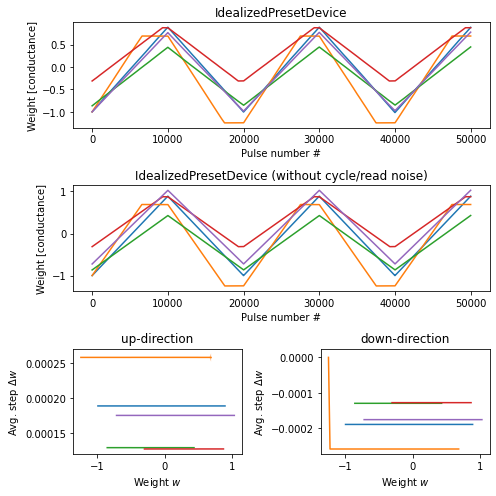

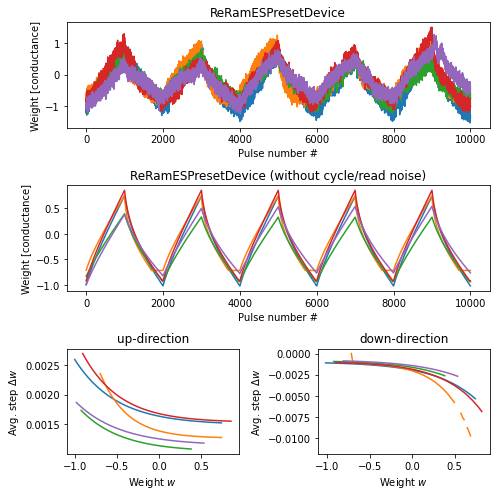

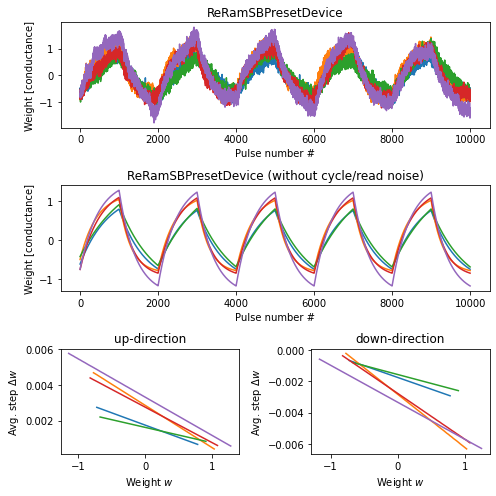

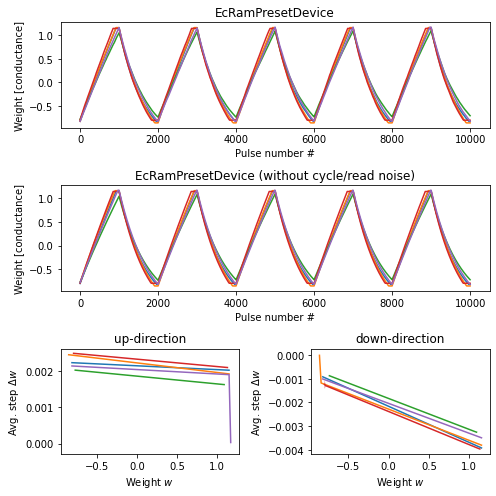

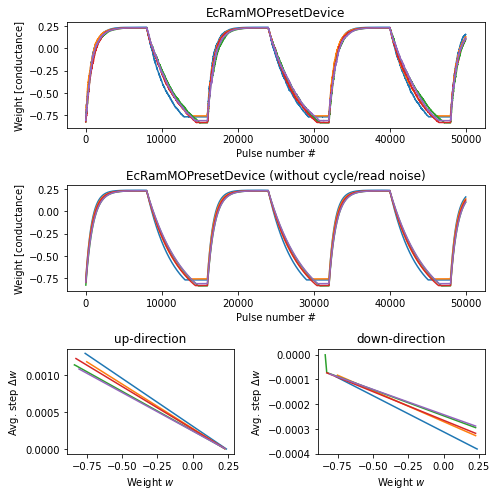

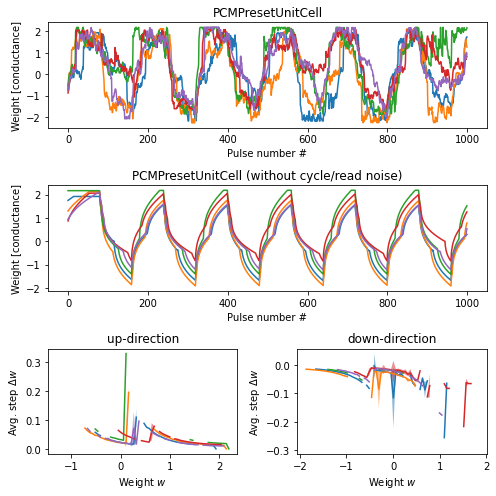

In [ ]:
# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()

# Note alternatively one can use plot_device_compact for a more compact
# plot.

# Idealized
plot_device(IdealizedPresetDevice(), n_steps=10000)

# ReRam based on ExpStep
plot_device(ReRamESPresetDevice(), n_steps=1000)

# ReRam based on SoftBounds
plot_device(ReRamSBPresetDevice())

# ECRAM
plot_device(EcRamPresetDevice(), n_steps=1000)

# Mo-ECRAM
plot_device(EcRamMOPresetDevice(gamma_up=5), n_steps=8000)

# PCM
plot_device(PCMPresetUnitCell(), n_steps=80)

#Capacitor

plot_device(CapacitorPresetDevice(n_steps=80))

plt.show()

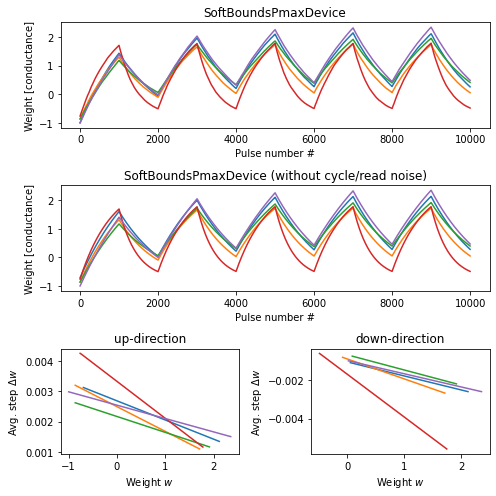

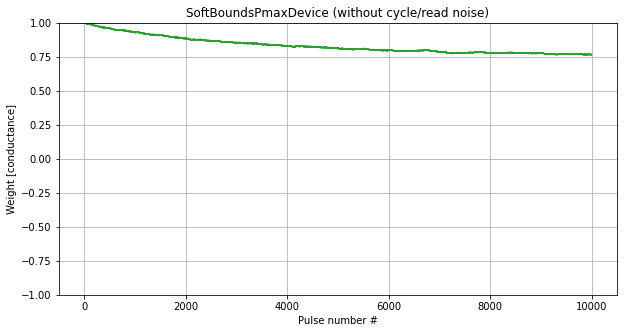

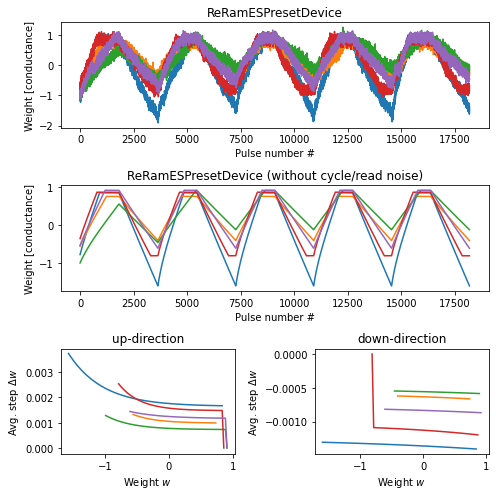

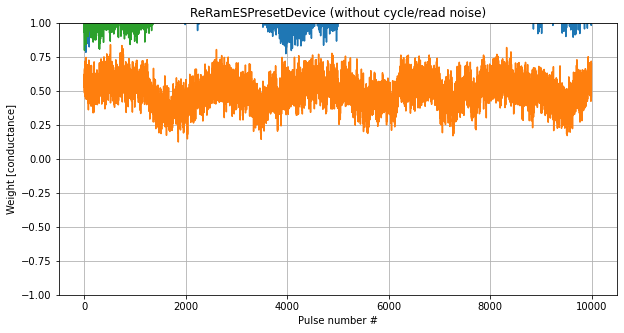

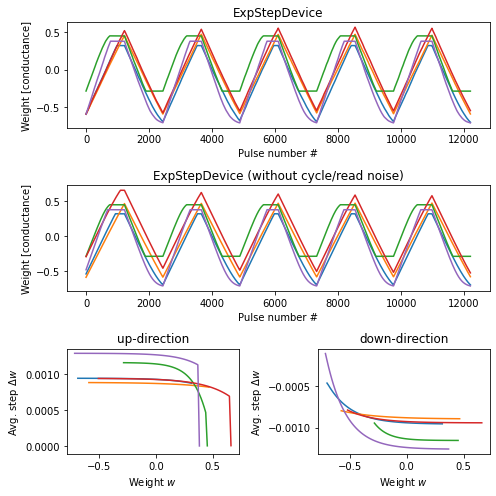

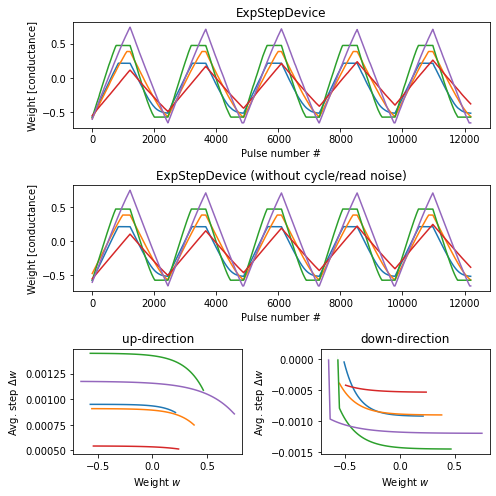

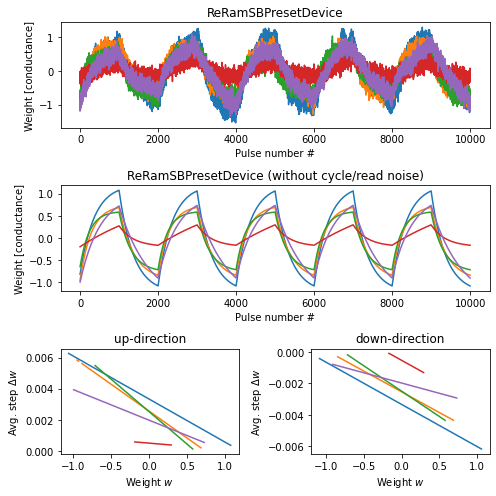

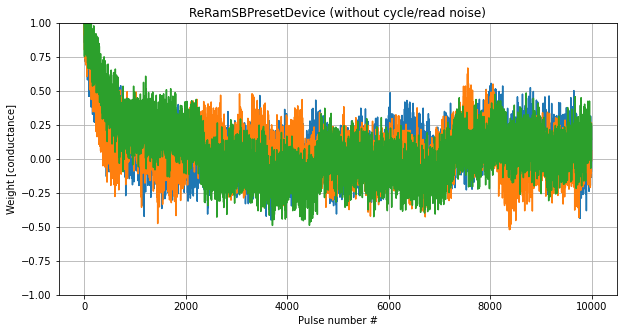

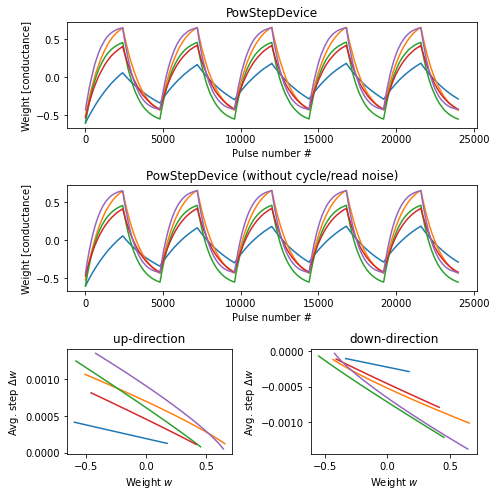

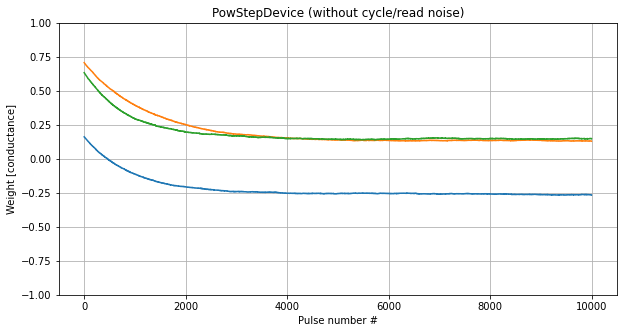

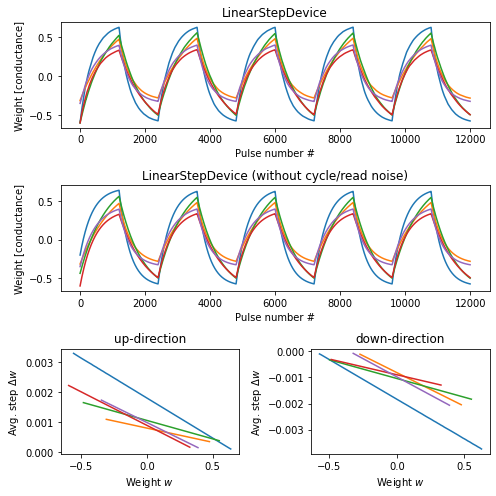

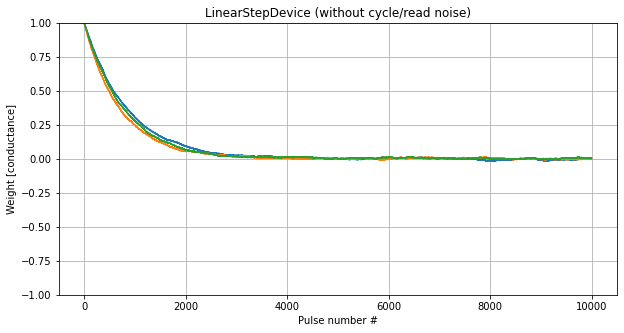

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()




plot_device(ReRamESPresetDevice(
    dw_min = 0.00135,
    up_down = 0.259359,

    w_max = 1.0,
    w_min = -1.0,

    a = -0.5,
    b = -0.2,
    gamma_up= 5,
    gamma_down = 1,
    A_up= -0.18445,
    A_down= -0.081404,

    # Device-to-device var.
    dw_min_dtod= 0.2,  # a little reduced compared to SB because of non-linearity
    up_down_dtod = 0.05,

    w_max_dtod= 0.3,
    w_min_dtod = 0.3,

    # Cycle-to_cycle.
    dw_min_std = 5.0,
    write_noise_std= 56.0,


))
plot_device_symmetry(ReRamESPresetDevice(
        dw_min = 0.00135,
    up_down = 0.259359,

    w_max = 1.0,
    w_min = -1.0,

    a = -0.5,
    b = -0.2,
    gamma_up= 5,
    gamma_down = 1,
    A_up= -0.18445,
    A_down= -0.081404,

    # Device-to-device var.
    dw_min_dtod= 0.2,  # a little reduced compared to SB because of non-linearity
    up_down_dtod = 0.05,

    w_max_dtod= 0.3,
    w_min_dtod = 0.3,

    # Cycle-to_cycle.
    dw_min_std = 5.0,
    write_noise_std= 56.0,




))





plot_device(ExpStepDevice())

plot_device(ExpStepDevice())


plot_device(ReRamSBPresetDevice(
    dw_min= 0.002,
    up_down = 0.0,

    w_max= 1.0,
    w_min= -1.0,

    mult_noise = False,

    # Device-to-device var.
    dw_min_dtod = 0.3,
    up_down_dtod= 0.01,  # assumes symmetry point corrected.

    w_max_dtod= 0.3/1.25,
    w_min_dtod = 0.3/0.75,

    # Cycle-to_cycle.
    dw_min_std = 3.75,
    write_noise_std= 56))

plot_device_symmetry(ReRamSBPresetDevice(    
    w_max= 1.5,
    w_min= -0.5,))



plot_device(PowStepDevice(
    construction_seed=0, corrupt_devices_prob=0.0, corrupt_devices_range=1000, diffusion=0.0, diffusion_dtod=0.0,  dw_min=0.001, dw_min_dtod=0.3, dw_min_std=0.3, enforce_consistency=True, lifetime=0.0, lifetime_dtod=0.0, perfect_bias=False, reset=0.0, reset_dtod=0.0, reset_std=0.01, up_down=0.0, up_down_dtod=0.01, w_max=0.6, w_max_dtod=0.3, w_min=-0.6, w_min_dtod=0.3, pow_gamma=1.0, pow_gamma_dtod=0.1, pow_up_down=0.0, pow_up_down_dtod=0.0, write_noise_std=0.0))
plot_device_symmetry(PowStepDevice(construction_seed=0, corrupt_devices_prob=0.0, corrupt_devices_range=1000, diffusion=0.0, diffusion_dtod=0.0,  dw_min=0.001, dw_min_dtod=0.3, dw_min_std=0.3, enforce_consistency=True, lifetime=0.0, lifetime_dtod=0.0, perfect_bias=False, reset=0.0, reset_dtod=0.0, reset_std=0.01, up_down=0.0, up_down_dtod=0.01, w_max=0.6, w_max_dtod=0.3, w_min=-0.6, w_min_dtod=0.3, pow_gamma=1.0, pow_gamma_dtod=0.1, pow_up_down=0.0, pow_up_down_dtod=0.0, write_noise_std=0.0))




plot_device(LinearStepDevice(
    
    gamma_up=1.0,
    gamma_down=1.0,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    allow_increasing=False,
    mean_bound_reference=True
))
plot_device_symmetry(LinearStepDevice(
    gamma_up=1.0,
    gamma_down=1.0,
    w_min=-0.5,
    w_max=1.5,
    up_down=0.0,
    dw_min=0.001,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    allow_increasing=False,
    mean_bound_reference=True
))

plt.show()

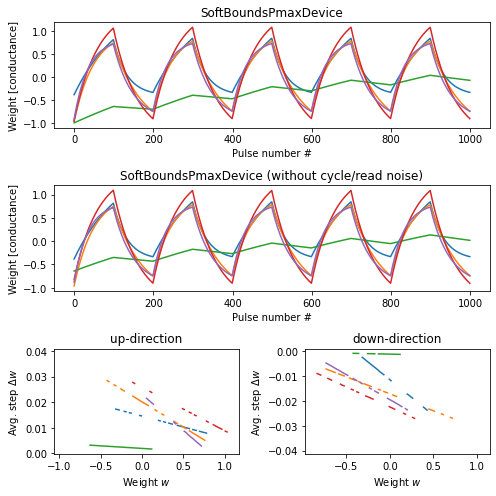

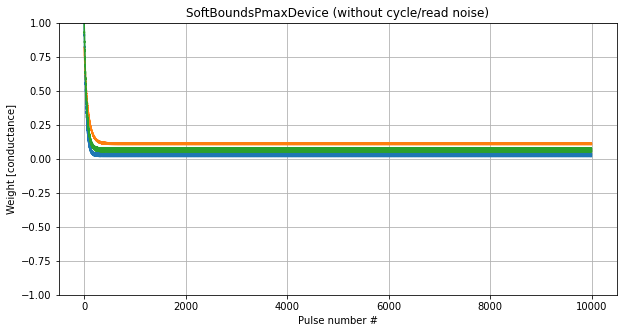

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()

# Note alternatively one can use plot_device_compact for a more compact
# plot.


# ReRam based on SoftBounds
plot_device(SoftBoundsPmaxDevice(
        p_max= 200,
  
    alpha= 0.01,
    
    w_min=-1,
    w_max=1,
    dw_min=0.0698,
    dw_min_std=0.011,
    up_down=0.9236,

   
    range_min= -1.0,


    range_max = 1.0,
)) #dtod device to device


plot_device_symmetry(SoftBoundsPmaxDevice(
    

            p_max= 200,
  
    alpha= 0.01,

    w_min=-1,
    w_max=1,

    dw_min_std=0,

       range_min= -1.0,


    range_max = 1.0,
))



In [ ]:
import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()

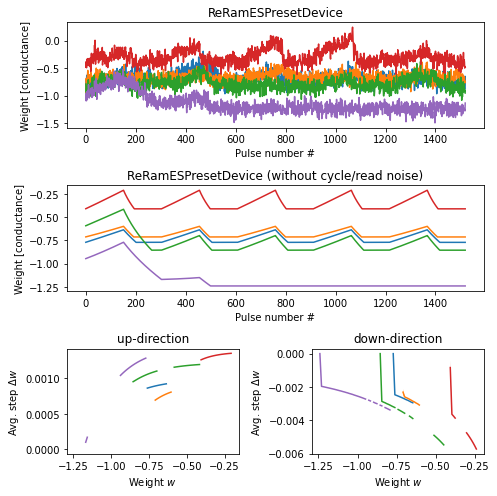

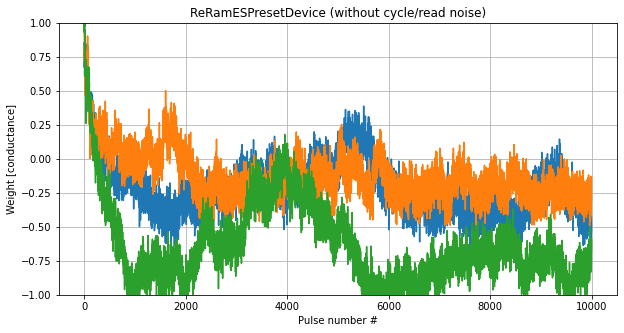

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()


plot_device(ReRamESPresetDevice(
    dw_min = 0.00135,
    up_down = 0.259359,

    w_max = 1.0,
    w_min = -1.0,

    a = -0.5,
    b = -0.5,
    gamma_up= 12,
    gamma_down = 5,
    A_up=1,
    A_down= -1,

    # Device-to-device var.
    dw_min_dtod= 0.2,  # a little reduced compared to SB because of non-linearity
    up_down_dtod = 0.05,

    w_max_dtod= 0.3,
    w_min_dtod = 0.3,

    # Cycle-to_cycle.
    dw_min_std = 5.0,
    write_noise_std= 56.0,


))
plot_device_symmetry(ReRamESPresetDevice(
        dw_min = 0.00135,
    up_down = 0.259359,

    w_max = 1.0,
    w_min = -1.0,

    a = -0.5,
    b = -0.5,
    gamma_up= 12,
    gamma_down = 5,
    A_up= -1,
    A_down= -0.081404,

    # Device-to-device var.
    dw_min_dtod= 0.2,  # a little reduced compared to SB because of non-linearity
    up_down_dtod = 0.05,

    w_max_dtod= 0.3,
    w_min_dtod = 0.3,

    # Cycle-to_cycle.
    dw_min_std = 5.0,
    write_noise_std= 56.0,



))







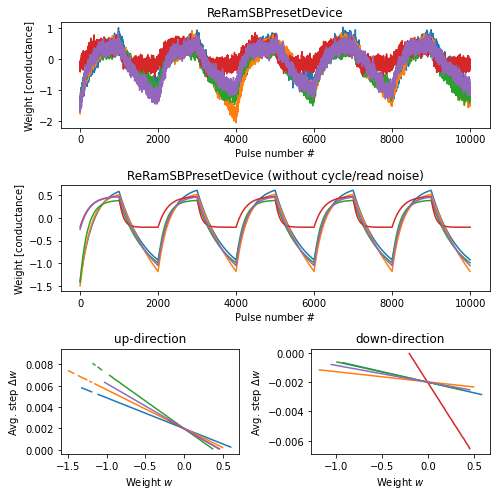

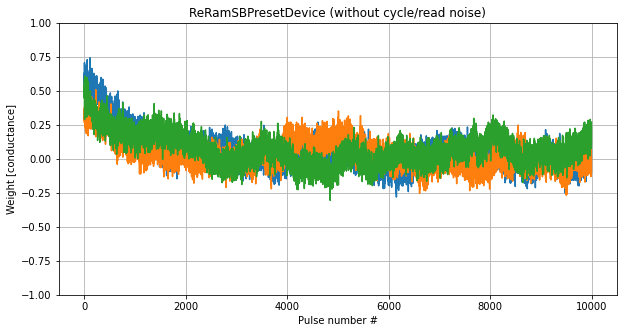

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()



plot_device(ReRamSBPresetDevice(
    dw_min= 0.002,
    up_down = 0.0,

    w_max= 0.5,
    w_min= -1.5,

    mult_noise = False,

    # Device-to-device var.
    dw_min_dtod = 0.0,
    up_down_dtod= 0.01,  # assumes symmetry point corrected.

    w_max_dtod= 0.3/1.25,
    w_min_dtod = 0.3/0.75,

    # Cycle-to_cycle.
    dw_min_std = 3.75,
    write_noise_std= 56))

plot_device_symmetry(ReRamSBPresetDevice(    
    dw_min= 0.001,
    up_down = 0.0,

    w_max= 0.5,
    w_min= -1.5,

    mult_noise = False,

    # Device-to-device var.
    dw_min_dtod = 0.0,
    up_down_dtod= 0.00,  # assumes symmetry point corrected.

    w_max_dtod= 0.3/1.25,
    w_min_dtod = 0.3/0.75,

    # Cycle-to_cycle.
    dw_min_std = 3.75,
    write_noise_std= 56))


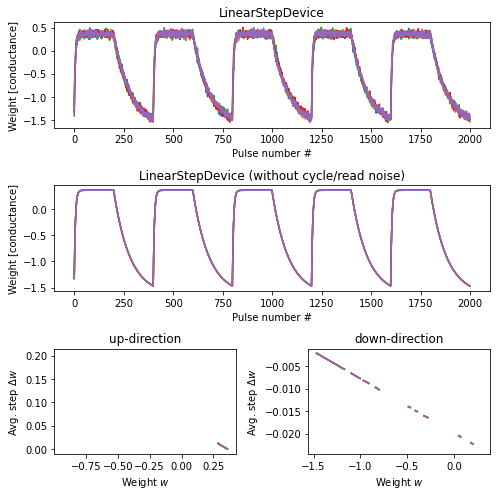

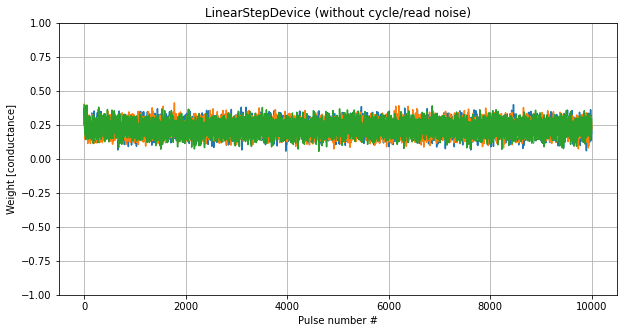

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()


plot_device(LinearStepDevice(
    
    w_min=-1.64,
    w_max=0.36,
    w_max_dtod=0,
    w_min_dtod=0,
    gamma_up=1.0,
    gamma_down=1,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    dw_min_dtod=0,
    dw_min=0.057,
    up_down=0.65,
    up_down_dtod=0,
    write_noise_std=0.7,
    allow_increasing=True,
    mean_bound_reference=True,
    
),n_steps=200)
plot_device_symmetry(LinearStepDevice(
    
    w_min=-1.64,
    w_max=0.36,
    w_max_dtod=0,
    w_min_dtod=0,
    gamma_up=1.0,
    gamma_down=1,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    dw_min_dtod=0,
    dw_min=0.057,
    up_down=0.65,
    up_down_dtod=0,
    write_noise_std=0.7,
    allow_increasing=True,
    mean_bound_reference=True,
))


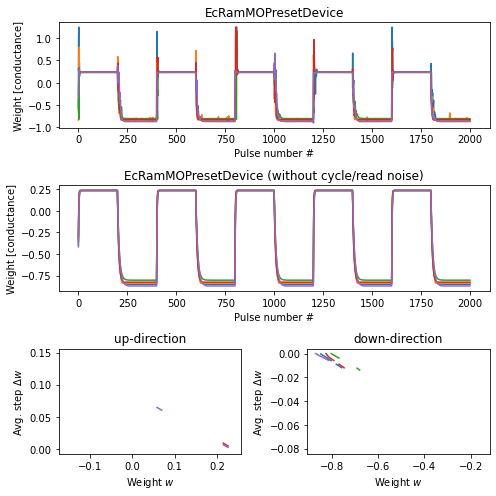

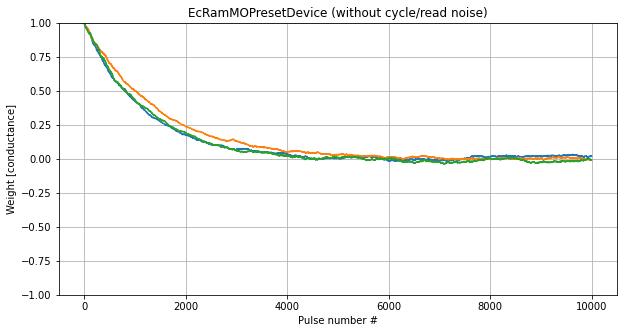

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()



# Mo-ECRAM
plot_device(EcRamMOPresetDevice(gamma_up=5,gamma_down=1,dw_min=0.1), n_steps=200)
plot_device_symmetry(EcRamMOPresetDevice(gamma_up=5,gamma_down=1))

In [ ]:
import matplotlib.pyplot as plt
from aihwkit.utils.visualization import plot_device,plot_device_compact,plot_device_symmetry
from aihwkit.simulator.configs.devices import PowStepDevice

plt.ion()
plot_device(
    PowStepDevice(w_min=-1, w_max=1.0, dw_min=0.1685, up_down=0.6572, pow_gamma=1.0, pow_gamma_dtod=0.0,
                  pow_up_down=0.02, w_min_dtod=0.0, w_max_dtod=0.0,dw_min_dtod=0,write_noise_std= 1), n_steps=200
            )
plt.show()

plot_device_symmetry(
    PowStepDevice(w_min=-1.50, w_max=0.50, dw_min=0.05, up_down=0.6572, pow_gamma=1.0, pow_gamma_dtod=0.0,
                  pow_up_down=0.02, w_min_dtod=0.0, w_max_dtod=0.0,write_noise_std= 1))


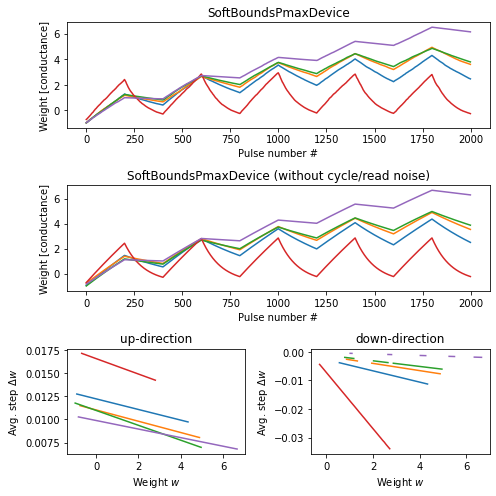

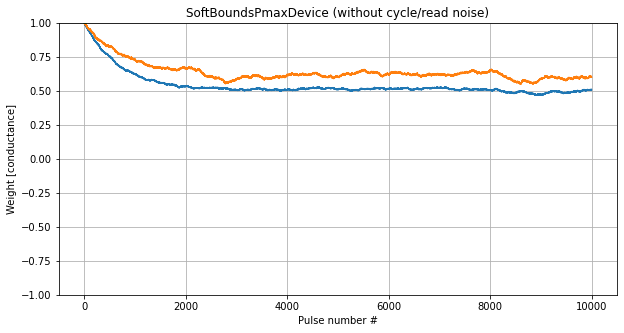

In [ ]:

# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 10: plotting of presets.

Plot the step response of different preset devices and preset configurations.
"""
# pylint: disable=invalid-name

import matplotlib.pyplot as plt

from aihwkit.utils.visualization import plot_device,plot_device_symmetry,plot_device_compact

from aihwkit.simulator.configs.devices import (
    TransferCompound,SoftBoundsPmaxDevice,PowStepDevice,ExpStepDevice,
    SoftBoundsDevice,LinearStepDevice)

from aihwkit.simulator.presets.devices import (
    ReRamSBPresetDevice, ReRamESPresetDevice, CapacitorPresetDevice,
    EcRamPresetDevice, IdealizedPresetDevice, EcRamMOPresetDevice,
    PCMPresetUnitCell,
)


plt.ion()


plot_device(SoftBoundsPmaxDevice(
    
#

    dw_min=0.058,
    up_down=0.78,
    p_max=200,
 #   allow_increasing=True,
 #   mean_bound_reference=False,
    
),n_steps=200)
plot_device_symmetry(SoftBoundsPmaxDevice(
    

    w_min=-0.5,
    w_max=1.5,
    up_down=0.5,
    dw_min=0.13,


 #   allow_increasing=True,
 #   mean_bound_reference=False,

))


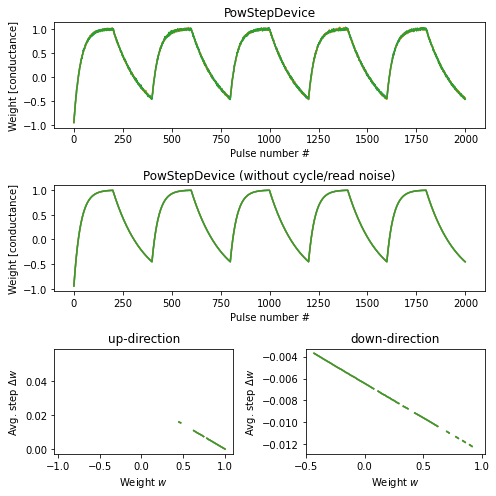

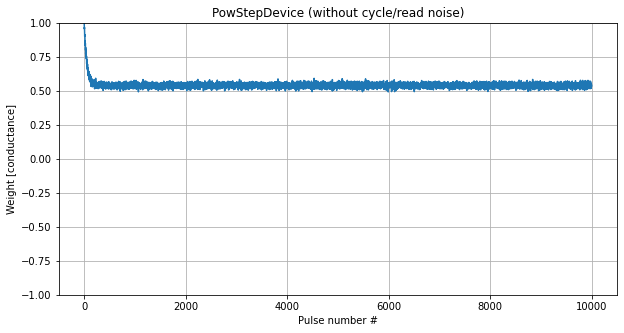

In [ ]:
import matplotlib.pyplot as plt
from aihwkit.utils.visualization import plot_device,plot_device_compact,plot_device_symmetry
from aihwkit.simulator.configs.devices import PowStepDevice

plt.ion()
plot_device(
    PowStepDevice(w_min=-1.0, w_max=1, dw_min=0.0578, dw_min_std=0.011721, up_down=0.78, up_down_dtod=0, pow_gamma=1, pow_gamma_dtod=0.0,
                  pow_up_down=0.02, w_min_dtod=0.0, w_max_dtod=0.0,dw_min_dtod=0,write_noise_std= 0.2), n_steps=200,n_traces=3
            )
plt.show()

plot_device_symmetry(
    PowStepDevice(w_min=-1.0, w_max=1, dw_min=0.0578, dw_min_std=0.011721, up_down=0.7, up_down_dtod=0, pow_gamma=1, pow_gamma_dtod=0.0,
                  pow_up_down=0.02, w_min_dtod=0.0, w_max_dtod=0.0,dw_min_dtod=0,write_noise_std= 0.2),n_traces=1)

In [ ]:
# tikiTaka V2 this is the one
# from my experimental data with pow fit


# -*- coding: utf-8 -*-

# (C) Copyright 2020, 2021 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""aihwkit example 4: analog CNN.

Mnist dataset on a LeNet5 inspired network based on the paper:
https://www.frontiersin.org/articles/10.3389/fnins.2017.00538/full

Learning rates of η = 0.01 for all the epochs with minibatch 8.
"""
# pylint: disable=invalid-name

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig, FloatingPointRPUConfig, UnitCellRPUConfig
from aihwkit.simulator.configs.devices import ConstantStepDevice, FloatingPointDevice,BufferedTransferCompound #soft bound device part of this
from aihwkit.simulator.presets.devices import ReRamSBPresetDevice #presents have to be imported from "Preset" library
from aihwkit.simulator.rpu_base import cuda
from aihwkit.simulator.presets.utils import PresetUpdateParameters,PresetIOParameters
from aihwkit.simulator.configs.devices import PowStepDevice


# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Path to store results
RESULTS = os.path.join(os.getcwd(), 'results', 'LENET5')

# Training parameters
SEED = 1
N_EPOCHS = 50
BATCH_SIZE = 8
LEARNING_RATE = 0.01
N_CLASSES = 10

# Select the device model to use in the training.
# * If `SingleRPUConfig(device=ConstantStepDevice())` then analog tiles with
#   constant step devices will be used,
# * If `FloatingPointRPUConfig(device=FloatingPointDevice())` then standard
#   floating point devices will be used
USE_ANALOG_TRAINING = True
if USE_ANALOG_TRAINING:
    RPU_CONFIG = UnitCellRPUConfig(
    device=BufferedTransferCompound(
        # Devices that compose the Tiki-taka compound.
        unit_cell_devices=[ #ReRamSBPresetDevice(), ReRamSBPresetDevice()
LinearStepDevice(
    
    w_min=-1.64,
    w_max=0.36,
    w_max_dtod=0,
    w_min_dtod=0,
    gamma_up=1.0,
    gamma_down=1,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    dw_min_dtod=0,
    dw_min=0.057,
    up_down=0.65,
    up_down_dtod=0,
    write_noise_std=0.7,
    allow_increasing=True,
    mean_bound_reference=True,
    
),
LinearStepDevice(
    
    w_min=-1.64,
    w_max=0.36,
    w_max_dtod=0,
    w_min_dtod=0,
    gamma_up=1.0,
    gamma_down=1,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0,
    dw_min_dtod=0,
    dw_min=0.057,
    up_down=0.65,
    up_down_dtod=0,
    write_noise_std=0.7,
    allow_increasing=True,
    mean_bound_reference=True,
    
)

        ],

        # Make some adjustments of the way Tiki-Taka is performed.
        units_in_mbatch=True,    # batch_size=1 anyway
        transfer_every=1,        # every batches do a transfer-read
            transfer_forward=PresetIOParameters(),
            transfer_update=PresetUpdateParameters(),


#modified portion

#  
      n_reads_per_transfer=1,  # one forward read for each transfer
#     
      gamma=0.0,               # all SGD weight in second device
#       
      scale_transfer_lr=True,  # in relative terms to SGD LR
#        
       transfer_lr=1.0,         # same transfer LR as for SGD
#        
      fast_lr=0.1,             # SGD update onto first matrix constant
#        transfer_columns=True    # transfer use columns (not rows)




    )
)



else:
    RPU_CONFIG = FloatingPointRPUConfig(device=FloatingPointDevice())
    
    # Make more adjustments (can be made here or above).
#rpu_config.forward.inp_res = 1/64   # 6 bit DAC
RPU_CONFIG.forward.out_res = -1



def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, validation_data


def create_analog_network():
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=RPU_CONFIG),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=RPU_CONFIG),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=RPU_CONFIG),
        nn.LogSoftmax(dim=1)
    )

    return model


def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []
    test_accuracy=[]

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)
            test_accuracy.append(accuracy)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Test error: {error:.2f}%\t'
                  f'Accuracy: {accuracy:.2f}%\t')

    # Save results and plot figures
    np.savetxt(os.path.join(RESULTS, "Test_error.csv"), test_error, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Train_Losses.csv"), train_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Valid_Losses.csv"), valid_losses, delimiter=",")
    np.savetxt(os.path.join(RESULTS, "Accuracy.csv"), test_accuracy, delimiter=",")
    plot_results(train_losses, valid_losses, test_error)

    return model, optimizer, (train_losses, valid_losses, test_error)


def plot_results(train_losses, valid_losses, test_error):
    """Plot results.

    Args:
        train_losses (List): training losses as calculated in the training_loop
        valid_losses (List): validation losses as calculated in the training_loop
        test_error (List): test error as calculated in the training_loop
    """
    fig = plt.plot(train_losses, 'r-s', valid_losses, 'b-o')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:2], ['Training Losses', 'Validation Losses'])
    plt.xlabel('Epoch number')
    plt.ylabel('Loss [A.U.]')
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_losses.png'))
    plt.close()

    fig = plt.plot(test_error, 'r-s')
    plt.title('aihwkit LeNet5')
    plt.legend(fig[:1], ['Validation Error'])
    plt.xlabel('Epoch number')
    plt.ylabel('Test Error [%]')
    plt.yscale('log')
    plt.ylim((5e-1, 1e2))
    plt.grid(which='both', linestyle='--')
    plt.savefig(os.path.join(RESULTS, 'test_error.png'))
    plt.close()


def main():
    """Train a PyTorch CNN analog model with the MNIST dataset."""
    # Make sure the directory where to save the results exist.
    # Results include: Loss vs Epoch graph, Accuracy vs Epoch graph and vector data.
    os.makedirs(RESULTS, exist_ok=True)
    torch.manual_seed(SEED)

    # Load datasets.
    train_data, validation_data = load_images()

    # Prepare the model.
    model = create_analog_network()
    if USE_CUDA:
        model.cuda()

    print(model)

    print(f'\n{datetime.now().time().replace(microsecond=0)} --- '
          f'Started LeNet5 Example')

    optimizer = create_sgd_optimizer(model, LEARNING_RATE)

    criterion = nn.CrossEntropyLoss()

    model, optimizer, _ = training_loop(model, criterion, optimizer, train_data, validation_data,
                                        N_EPOCHS)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed LeNet5 Example')


if __name__ == '__main__':
    # Execute only if run as the entry point into the program
    main()

ModuleNotFoundError: ignored

In [ ]:
"""aihwkit example 19: Analog summary on LeNet.
Extracts analog information in the form of a printed table.
The information can also be accessed via the returned AnalogInfo object.
"""
# pylint: disable=invalid-name

# Imports from PyTorch.
from torch import nn

# Imports from aihwkit.
from aihwkit.nn import AnalogLinear, AnalogConv2d, AnalogSequential
from aihwkit.simulator.configs import SingleRPUConfig
from aihwkit.simulator.configs.devices import ConstantStepDevice
from aihwkit.utils.analog_info import analog_summary

# Define a single-layer network, using a constant step device type.
rpu_config = SingleRPUConfig(device=ConstantStepDevice())

channel = [16, 32, 512, 128]
model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=10, rpu_config=rpu_config),
        nn.LogSoftmax(dim=1)
    )
# TODO: add mapped examples

# print(model.__class__.__name__)
analog_summary(model, (1, 1, 28, 28))

ModuleNotFoundError: ignored